In [21]:
from matplotlib import pyplot as plt
import numpy as np
from time import time
from os.path import abspath, join
import sys
from glob import glob
import vaex
from hammer import dm
root_dir = abspath(join('..', '..'))
data_dir = join(root_dir, 'Data')
sys.path.append(root_dir)
from utils import (plot_corner, plot_chain, plot_fit, style, calculate_probs, get_params, get_initial_position_normal)

In [2]:
style()

In [12]:
zfiles = glob(join(root_dir, 'Data', 'Effective-Volume-no', 'z*.hdf5'))
zfiles.sort()
wfiles = glob(join(root_dir, 'Data', 'Velocity-Distribution-no', 'w*.hdf5'))
wfiles.sort()
zfiles, wfiles

(['/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(-0.10)_(0.10).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.10)_(0.16).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.16)_(0.20).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.20)_(0.23).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.23)_(0.26).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.26)_(0.28).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.28)_(0.30).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.30)_(0.32).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.32)_(0.34).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.34)_(0.36).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.36)_(0.37).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.37)_(0.39).hdf5',
  '

In [13]:
index = 0
zfile = zfiles[index]
wfile = wfiles[index]
zdata = vaex.open(zfile)
zmid = zdata['zmid'].to_numpy()
znum = zdata['znum'].to_numpy()
zerr = zdata['zerr'].to_numpy()

wdata = vaex.open(wfile)
wmid = wdata['wmid'].to_numpy()
wnum = wdata['wnum'].to_numpy()
werr = wdata['werr'].to_numpy()

zdata = (zmid, znum, zerr)
wdata = (wmid, wnum, werr)

In [14]:
# Baryonic density, check table 1 from this https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.121.081101
rhob = [
    0.0104, 0.0277, 0.0073, 0.0005, 0.0006, 0.0018,
    0.0018, 0.0029, 0.0072, 0.0216, 0.0056, 0.0015
]
sigmaz = [
    3.7, 7.1, 22.1, 39.0, 15.5, 7.5, 12.0, 
    18.0, 18.5, 18.5, 20.0, 20.0]
rhoDM = [0.016]
log_nu0 = [0]
R = [3.4E-3]
zsun = [0]
w0 = [-7.]
sigma1 = 5.
sigma2 = 10.
log_sigmaw = [np.log(sigma1)]
q_sigmaw = [sigma1/sigma2]
a1 = 0.9
a2 = 0.1
log_a = [np.log(a1)]
q_a = [a2/a1]

theta = np.array([rhob + sigmaz + rhoDM+ log_nu0 + R + zsun + w0 + log_sigmaw + q_sigmaw + log_a + q_a]).flatten()
theta.shape

(33,)

In [15]:
locs_raw = dict(
    rhoDM=-0.05,
    log_nu0=-1,
    R=3.4E-3,
    zsun=-100,
    w0=-15,
    log_sigmaw=np.log(1),
    q_sigmaw=0.,
    log_a=np.log(0.01),
    q_a=0.,
)

scales_raw = dict(
    rhoDM=0.15,
    log_nu0=3,
    R=0.6E-3,
    zsun=200,
    w0=15,
    log_sigmaw=np.log(50)-locs_raw['log_sigmaw'],
    q_sigmaw=1.,
    log_a=np.log(100)-locs_raw['log_a'],
    q_a=1.0
)

keys = list(locs_raw.keys())
locs = np.array(list(locs_raw.values()))
scales = np.array(list(scales_raw.values()))

[(k, loc, th, s+loc) for k, loc, th, s in zip(keys, locs, theta[24:], scales)]

[('rhoDM', -0.05, 0.016, 0.09999999999999999),
 ('log_nu0', -1.0, 0.0, 2.0),
 ('R', 0.0034, 0.0034, 0.004),
 ('zsun', -100.0, 0.0, 100.0),
 ('w0', -15.0, -7.0, 0.0),
 ('log_sigmaw', 0.0, 1.6094379124341003, 3.912023005428146),
 ('q_sigmaw', 0.0, 0.5, 1.0),
 ('log_a', -4.605170185988091, -0.10536051565782628, 4.605170185988093),
 ('q_a', 0.0, 0.11111111111111112, 1.0)]

In [16]:
ndim = len(locs)+24
nwalkers = 10*ndim+2
ndim, nwalkers

(33, 332)

In [17]:
p0 = dm.generate_p0(nwalkers, locs, scales)
p0.shape

(332, 33)

In [18]:
for p in p0:
    print(dm.log_prob(p, zdata, wdata, locs, scales))

(43.961604134345016, -1155.4376940521527)
(45.987416528061786, -23350.71860756642)
(38.73847711141105, -3691473.564037296)
(47.484326433013464, -2552.8939586500405)
(42.179406695248005, -3994.4216384151946)
(49.31954084325318, -32896.315963283894)
(45.2852259888377, -299017900.5390468)
(44.29599054515168, -614.7789118407898)
(47.79605911507945, -27913442.82550062)
(39.557771462397504, -3066053.82405234)
(46.68586381348438, -24464.049109951946)
(40.348020149857135, -1477.029739407025)
(43.89212498114523, -2525.756028787324)
(39.65810494965119, -1005679.4454523135)
(47.391955695876064, -511977.3810715568)
(46.18277565459974, -13182.279708281847)
(41.999774344098846, -245437.67948990987)
(45.19225266587138, -1007.6289804767489)
(39.67750917250094, -699919.5890743339)
(43.22700135947548, -2038005.511992273)
(39.25440978548335, -733888.5216778076)
(46.61562954937812, -8505.556239631273)
(47.78689709489165, -477.9765725103814)
(45.036147466650704, -10673.822169478493)
(48.43590815688525, -78

In [19]:
p0_flat = p0.reshape(-1, ndim)
dm.log_prob_par(p0_flat, zdata, wdata, locs, scales)

array([[ 4.39616041e+01, -1.19939930e+03, -1.15543769e+03],
       [ 4.59874165e+01, -2.33967060e+04, -2.33507186e+04],
       [ 3.87384771e+01, -3.69151230e+06, -3.69147356e+06],
       [ 4.74843264e+01, -2.60037829e+03, -2.55289396e+03],
       [ 4.21794067e+01, -4.03660105e+03, -3.99442164e+03],
       [ 4.93195408e+01, -3.29456355e+04, -3.28963160e+04],
       [ 4.52852260e+01, -2.99017946e+08, -2.99017901e+08],
       [ 4.42959905e+01, -6.59074902e+02, -6.14778912e+02],
       [ 4.77960591e+01, -2.79134906e+07, -2.79134428e+07],
       [ 3.95577715e+01, -3.06609338e+06, -3.06605382e+06],
       [ 4.66858638e+01, -2.45107350e+04, -2.44640491e+04],
       [ 4.03480201e+01, -1.51737776e+03, -1.47702974e+03],
       [ 4.38921250e+01, -2.56964815e+03, -2.52575603e+03],
       [ 3.96581049e+01, -1.00571910e+06, -1.00567945e+06],
       [ 4.73919557e+01, -5.12024773e+05, -5.11977381e+05],
       [ 4.61827757e+01, -1.32284625e+04, -1.31822797e+04],
       [ 4.19997743e+01, -2.45479679e+05

(33,)


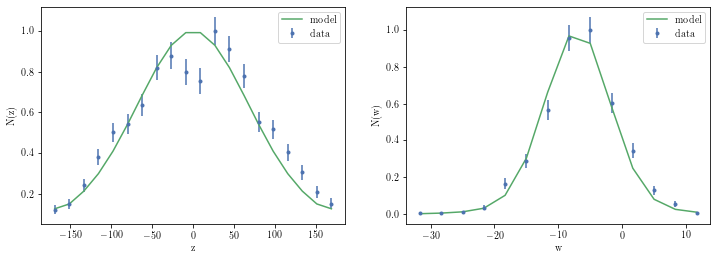

(57.199650418000715, 99.365389458818)

In [20]:
print(theta.shape)
zmod = dm.fz(zmid, theta)
wmod = dm.fw(wmid, theta)

# plot
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].errorbar(zmid, znum, yerr=zerr, fmt='.', label='data')
ax[0].plot(zmid, zmod, label='model')
ax[0].set_xlabel('z')
ax[0].set_ylabel('N(z)')
ax[0].legend()
ax[1].errorbar(wmid, wnum, yerr=werr, fmt='.', label='data')
ax[1].plot(wmid, wmod, label='model')
ax[1].set_xlabel('w')
ax[1].set_ylabel('N(w)')
ax[1].legend()
plt.show()
dm.log_prob(theta, zdata, wdata, locs, scales)

In [22]:
time0 = time()
for i in range(5):
    print("\t",i)
    t0 = time()
    chain = dm.mcmc(500, nwalkers, p0, zdata, wdata, locs, scales, dz=1, verbose=True, parallel=True)
    print(time() - t0, "s")
    burn = 300
    keys, locs_normal, scales_normal = get_initial_position_normal(keys, chain[burn:], np.arange(24, 24+len(keys)))
    p0 = dm.generate_p0(nwalkers, locs_normal, scales_normal, norm=True)
    t0 = time()
    chain = dm.mcmc(500, nwalkers, p0, zdata, wdata, locs, scales, dz=1, verbose=True, parallel=True)
    print(time() - t0, "s")
    p0 = chain[-1]
print("total", time() - time0, "s")

	 0
13.985057353973389 s
13.847662925720215 s
	 1
14.309829235076904 s
14.343254566192627 s
	 2
13.811125993728638 s
13.538026571273804 s
	 3
13.324973106384277 s
13.551076650619507 s
	 4
13.408651113510132 s
13.474974632263184 s
total 137.76739478111267 s


In [23]:
calculate_probs(dm, chain, ndim, zdata, wdata, locs, scales, batch=100)

array([[  50.13383894, -217.30520726, -167.17136832],
       [  50.79600231,  -45.14107585,    5.65492645],
       [  48.07900188,  -33.14401585,   14.93498603],
       ...,
       [  45.45118885,   64.86396094,  110.31514979],
       [  42.1139847 ,   64.85101513,  106.96499983],
       [  39.9187044 ,   64.14370656,  104.06241096]])

10it [00:01,  7.04it/s]


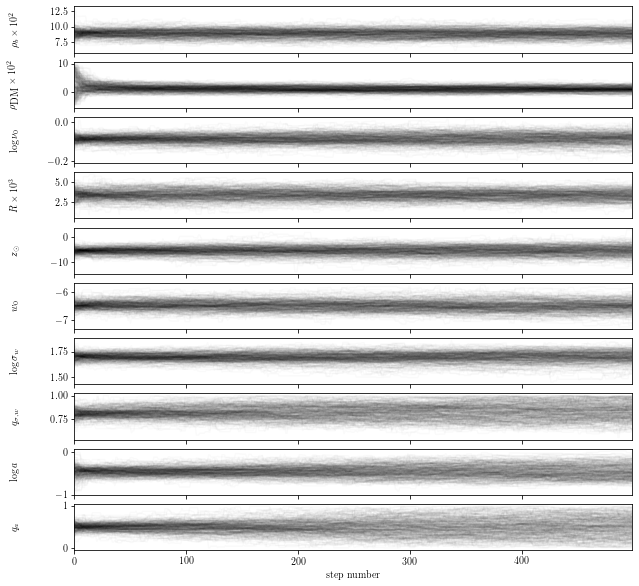

In [24]:
labels = [r'$\rho_b\times 10^2$', r'$\rho_{\textup{DM}}\times 10^2$', r'$\log \nu_0$', 
          r'$R\times 10^3$', r'$z_{\odot}$', r'$w_0$', 
          r'$\log \sigma_{w}$', r'$q_{\sigma,w}$', r'$\log a$', r'$q_a$']
labs = ['rhob', 'rhoDM', 'log_nu0', 'R', 'zsun', 'w0', 'log_sigmaw', 'q_sigmaw', 'log_a', 'q_a']
indexes = [12, 24, 25, 26, 27, 28, 29, 30, 31, 32]

params = get_params(chain, indexes, labs)
plot_chain(params, labels, figsize=(10,10), alpha=0.02)

### long

In [25]:
p0_next = chain[-1]
t0 = time()
chain = dm.mcmc(2000, nwalkers, p0_next, zdata, wdata, locs, scales, dz=1, verbose=True, parallel=True)
print(time() - t0, "s")
chain.shape

52.84707593917847 s


(2000, 332, 33)

10it [00:01,  7.69it/s]


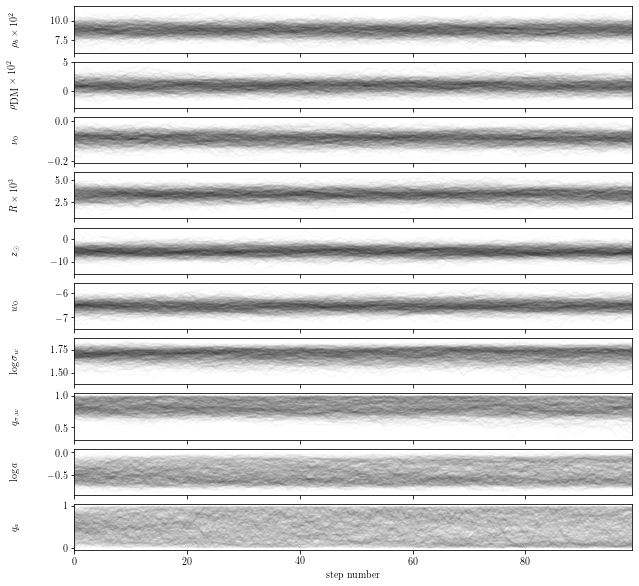

In [26]:
thin = 20
labels = [r'$\rho_b\times 10^2$', r'$\rho_{\textup{DM}}\times 10^2$', r'$\nu_0$', 
          r'$R\times 10^3$', r'$z_{\odot}$', r'$w_0$', 
          r'$\log \sigma_{w}$', r'$q_{\sigma,w}$', r'$\log a$', r'$q_a$']
labs = ['rhob', 'rhoDM', 'nu0', 'R', 'zsun', 'w0', 'log_sigmaw', 'q_sigmaw', 'log_a', 'q_a']
indexes = [12, 24, 25, 26, 27, 28, 29, 30, 31, 32]

params = get_params(chain[::thin], indexes, labs)
plot_chain(params, labels, figsize=(10,10), alpha=0.02)

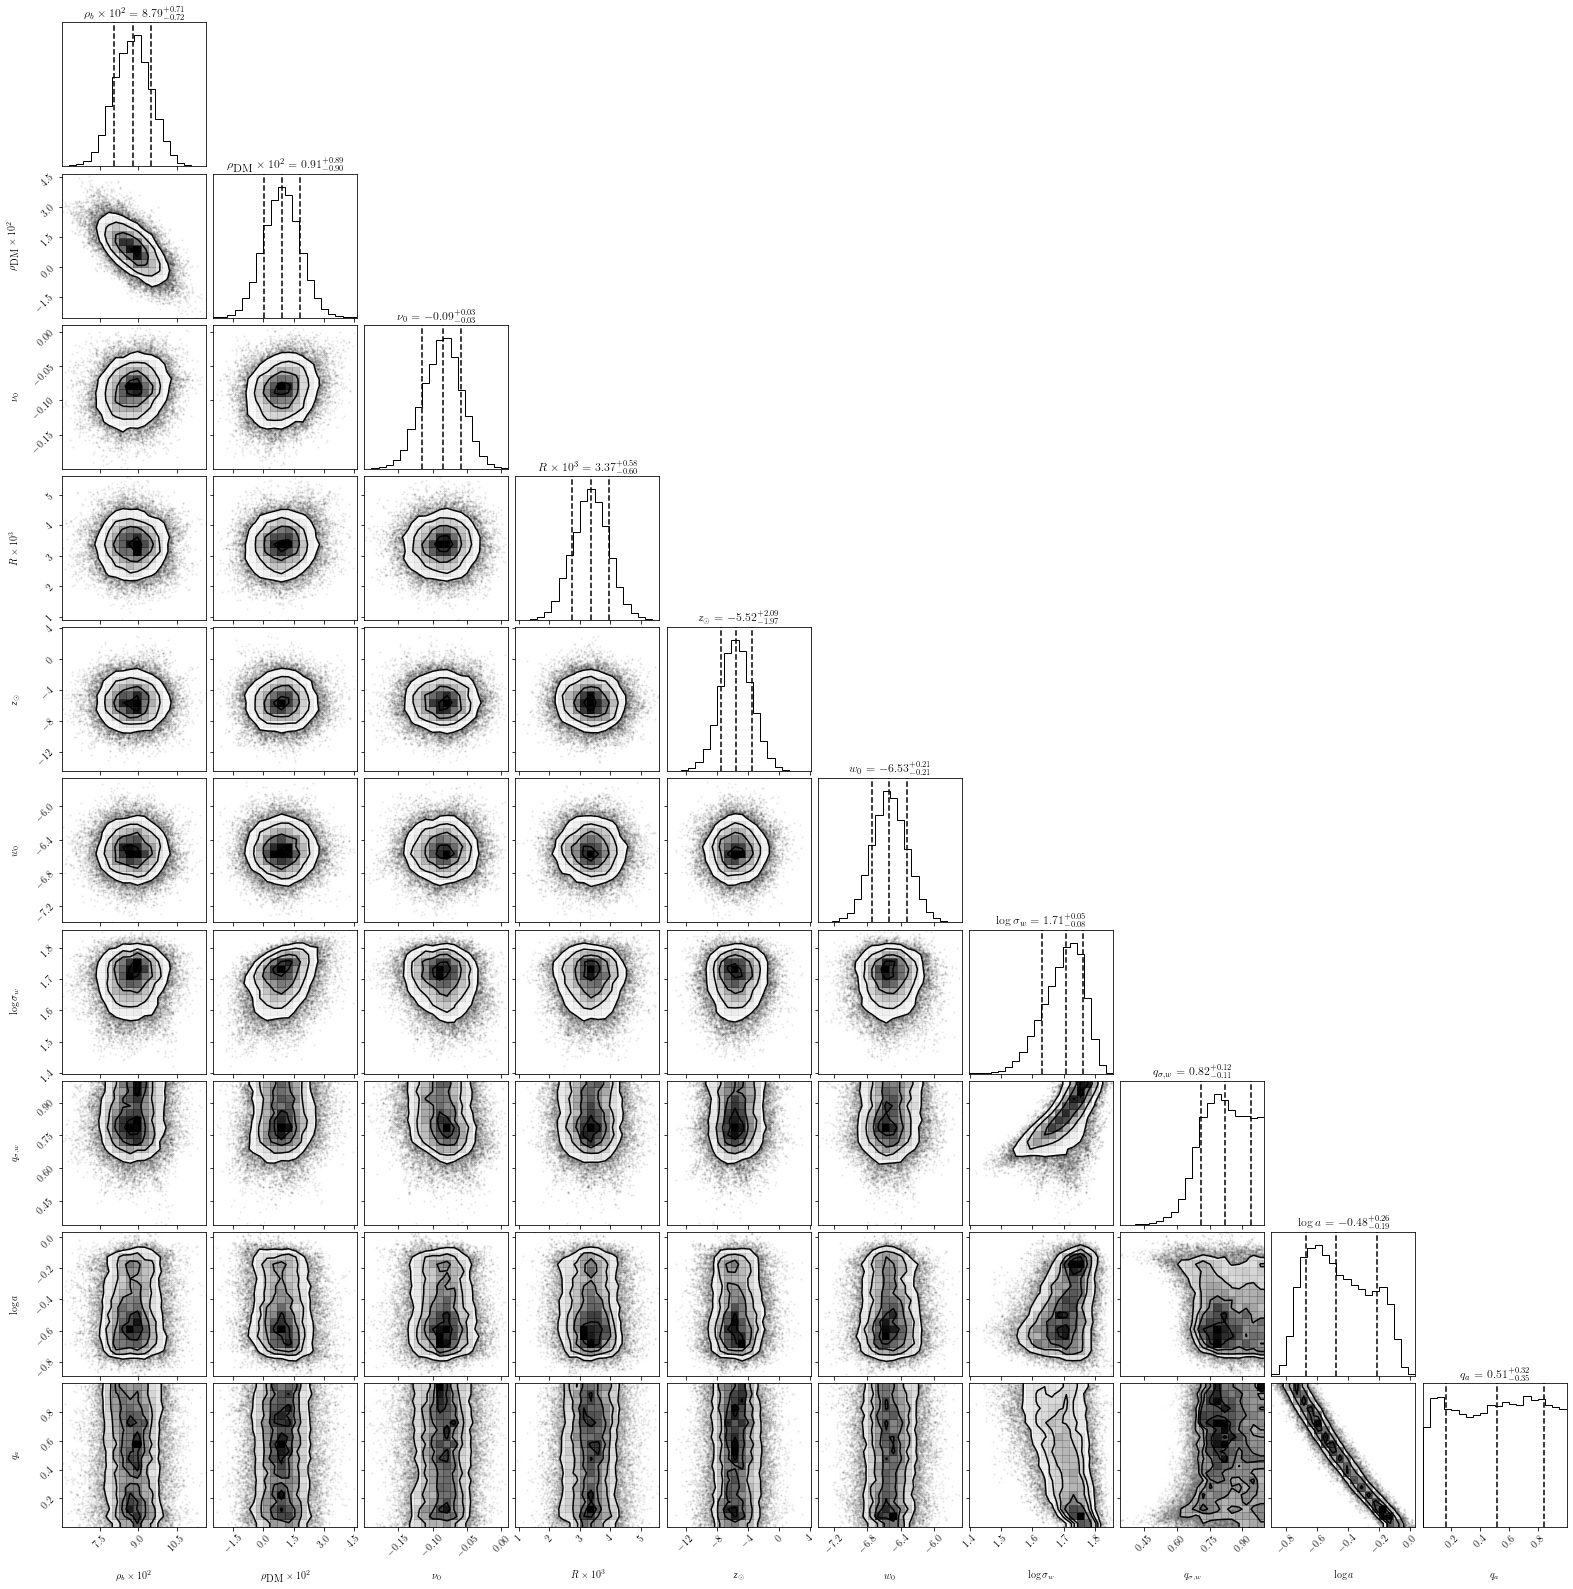

In [27]:
labels = [r'$\rho_b\times 10^2$', r'$\rho_{\textup{DM}}\times 10^2$', r'$\nu_0$', 
          r'$R\times 10^3$', r'$z_{\odot}$', r'$w_0$', 
          r'$\log \sigma_{w}$', r'$q_{\sigma,w}$', r'$\log a$', r'$q_a$']
labs = ['rhob', 'rhoDM', 'nu0', 'R', 'zsun', 'w0', 'log_sigmaw', 'q_sigmaw', 'log_a', 'q_a']
indexes = [12, 24, 25, 26, 27, 28, 29, 30, 31, 32]
chain_thin = chain[::thin]

params = get_params(chain_thin, indexes, labs)
plot_corner(params, labels)

(33200, 33)


100%|██████████| 5000/5000 [00:03<00:00, 1502.95it/s]


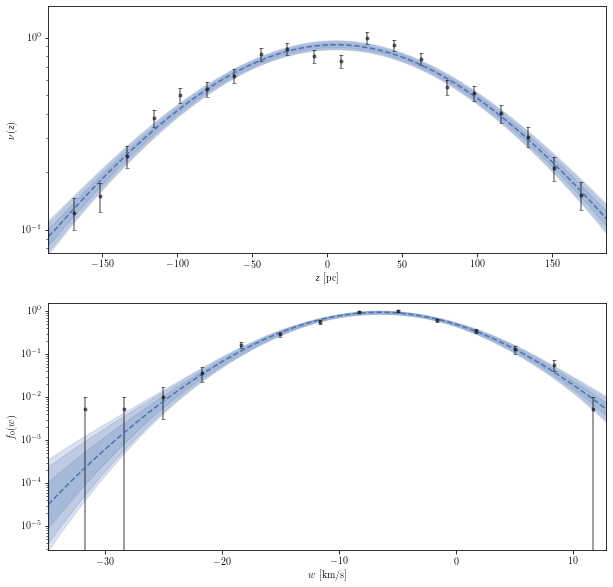

In [28]:
plot_fit(dm, zdata, wdata, chain_thin, ndim, n=5_000)

In [25]:
probs = calculate_probs(dm, chain_thin, ndim, zdata, wdata, locs, scales)

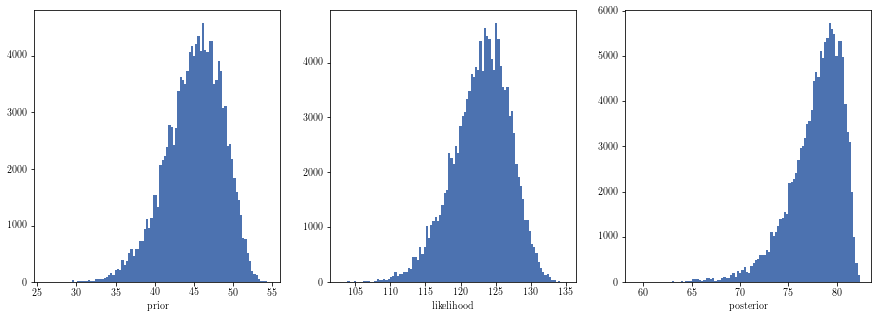

134.83256058584072

In [26]:
prior = probs[:, 0]
likelihood = probs[:, 2]
posterior = probs[:, 1]
# plot histogram of probabilities
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].hist(prior, bins=100)
axes[0].set_xlabel('prior')
axes[1].hist(likelihood, bins=100)
axes[1].set_xlabel('likelihood')
axes[2].hist(posterior, bins=100)
axes[2].set_xlabel('posterior')
plt.show()
likelihood.max()

# Script

do mcmc for

* same $N$, different $z$
* same $z$, different $N$

Each 'running' contains
1. generate_init: initial position for walkers.
    * this is done by the experiment above.
2. run_mcmc: run true mcmc for 10_000 steps.
3. plot trace: plot trace plot for preliminary mcmc.
4. plot corner: plot corner plot for the long run.
5. plot fit: fitting plot for vertical density and vertical dispersion.
6. calculate bic & aic: calculate bic and aic for the long run.

All of these functionalities are implemented in `mcmc.py` at `utils`.

Just run the `program.py` at `script`.
To automate the process for all data, run `run_program.py` at `script`.

# Mock comparison

run mcmc but now for mock data comparison.

`Data/MCMC/dm_mock/mock/comp`

It contains mock data with different number of data points.
1000, 5000, 10000, 20000, 50000, 100000, 200000, 500000, 1000000

This comparison is done to see the prediction power of the model.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from time import time
from os.path import abspath, join
from scipy.stats import norm
import sys
from glob import glob
import vaex
from hammer import dm
root_dir = abspath(join('..', '..'))
data_dir = join(root_dir, 'Data')
sys.path.append(root_dir)

In [14]:
from utils import style, calculate_probs, plot_chain, plot_corner, plot_fit, get_initial_position_normal, get_params

style()

In [3]:
zfiles = glob(join(root_dir, 'Data', 'MCMC', 'dm_mock', 'mock', 'comp', 'z*.hdf5'))
zfiles.sort()
wfiles = glob(join(root_dir, 'Data', 'MCMC', 'dm_mock', 'mock', 'comp','w*.hdf5'))
wfiles.sort()
zfiles, wfiles

(['/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/comp/z_0001000.hdf5',
  '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/comp/z_0005000.hdf5',
  '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/comp/z_0010000.hdf5',
  '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/comp/z_0050000.hdf5',
  '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/comp/z_0100000.hdf5',
  '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/comp/z_0500000.hdf5',
  '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/comp/z_1000000.hdf5'],
 ['/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/comp/w_0001000.hdf5',
  '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/comp/w_0005000.hdf5',
  '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/comp/w_0010000.hdf5',
  '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/comp/w_0050000.hdf5',
  '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/comp/w_0100000.hdf5',
  '/home2/s20321005/Thesis-Project/Data

In [4]:
index = 5
zfile = zfiles[index]
wfile = wfiles[index]
zdata = vaex.open(zfile)
zmid = zdata['zmid'].to_numpy()
znum = zdata['znum'].to_numpy()
zerr = zdata['zerr'].to_numpy()

wdata = vaex.open(wfile)
wmid = wdata['wmid'].to_numpy()
wnum = wdata['wnum'].to_numpy()
werr = wdata['werr'].to_numpy()

zdata = (zmid, znum, zerr)
wdata = (wmid, wnum, werr)

In [5]:
# Baryonic density, check table 1 from this https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.121.081101
rhob = [
    0.0104, 0.0277, 0.0073, 0.0005, 0.0006, 0.0018,
    0.0018, 0.0029, 0.0072, 0.0216, 0.0056, 0.0015
]
sigmaz = [
    3.7, 7.1, 22.1, 39.0, 15.5, 7.5, 12.0, 
    18.0, 18.5, 18.5, 20.0, 20.0]
rhoDM = [0.016]
log_nu0 = [0]
R = [3.4E-3]
zsun = [30]
w0 = [-7.]
sigma1 = 5.
sigma2 = 10.
log_sigmaw = [np.log(sigma1)]
q_sigmaw = [sigma1/sigma2]
a1 = 0.9
a2 = 0.1
log_a = [np.log(a1)]
q_a = [a2/a1]

theta = np.array([rhob + sigmaz + rhoDM+ log_nu0 + R + zsun + w0 + log_sigmaw + q_sigmaw + log_a + q_a]).flatten()
theta.shape

(33,)

In [6]:
locs_raw = dict(
    rhoDM=-0.05,
    log_nu0=-1,
    R=3.4E-3,
    zsun=-100,
    w0=-15,
    log_sigmaw=np.log(1),
    q_sigmaw=0.,
    log_a=np.log(0.01),
    q_a=0.,
)

scales_raw = dict(
    rhoDM=0.15,
    log_nu0=3,
    R=0.6E-3,
    zsun=200,
    w0=15,
    log_sigmaw=np.log(50)-locs_raw['log_sigmaw'],
    q_sigmaw=1.,
    log_a=np.log(100)-locs_raw['log_a'],
    q_a=1.0
)

keys = list(locs_raw.keys())
locs = np.array(list(locs_raw.values()))
scales = np.array(list(scales_raw.values()))

[(k, loc, th, s+loc) for k, loc, th, s in zip(keys, locs, theta[24:], scales)]

[('rhoDM', -0.05, 0.016, 0.09999999999999999),
 ('log_nu0', -1.0, 0.0, 2.0),
 ('R', 0.0034, 0.0034, 0.004),
 ('zsun', -100.0, 30.0, 100.0),
 ('w0', -15.0, -7.0, 0.0),
 ('log_sigmaw', 0.0, 1.6094379124341003, 3.912023005428146),
 ('q_sigmaw', 0.0, 0.5, 1.0),
 ('log_a', -4.605170185988091, -0.10536051565782628, 4.605170185988093),
 ('q_a', 0.0, 0.11111111111111112, 1.0)]

(33,)


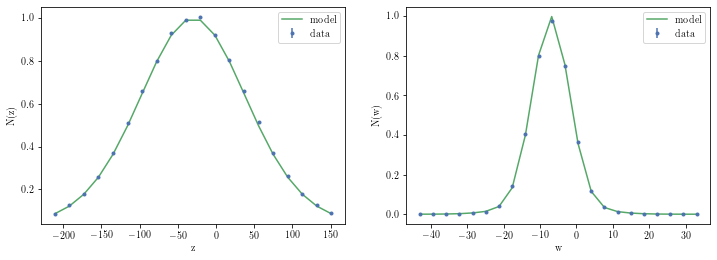

(57.199650418000715, 174.36957815363962)

In [7]:
print(theta.shape)
zmod = dm.fz(zmid, theta)
wmod = dm.fw(wmid, theta)

# plot
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].errorbar(zmid, znum, yerr=zerr, fmt='.', label='data')
ax[0].plot(zmid, zmod, label='model')
ax[0].set_xlabel('z')
ax[0].set_ylabel('N(z)')
ax[0].legend()
ax[1].errorbar(wmid, wnum, yerr=werr, fmt='.', label='data')
ax[1].plot(wmid, wmod, label='model')
ax[1].set_xlabel('w')
ax[1].set_ylabel('N(w)')
ax[1].legend()
plt.show()
dm.log_prob(theta, zdata, wdata, locs, scales)

In [8]:
ndim = len(locs)+24
nwalkers = 10*ndim+2
ndim, nwalkers

(33, 332)

In [9]:
p0 = dm.generate_p0(nwalkers, locs, scales)
p0.shape

(332, 33)

In [10]:
p0_flat = p0.reshape(-1, ndim)
dm.log_prob_par(p0_flat, zdata, wdata, locs, scales)

array([[ 4.18505720e+01, -7.76934836e+05, -7.76892985e+05],
       [ 4.66981192e+01, -4.49216669e+05, -4.49169971e+05],
       [ 4.45031950e+01, -1.23458169e+11, -1.23458169e+11],
       [ 4.24057009e+01, -2.02919475e+05, -2.02877069e+05],
       [ 4.38373737e+01, -5.13158388e+06, -5.13154004e+06],
       [ 4.80300376e+01, -5.39382272e+05, -5.39334242e+05],
       [ 4.31197892e+01, -4.69599450e+06, -4.69595138e+06],
       [ 4.01913946e+01, -3.41602889e+07, -3.41602487e+07],
       [ 4.32943955e+01, -1.22951145e+07, -1.22950712e+07],
       [ 4.19360537e+01, -1.28941032e+09, -1.28941028e+09],
       [ 4.56543414e+01, -3.42119011e+09, -3.42119006e+09],
       [ 4.12416089e+01, -7.49055719e+06, -7.49051595e+06],
       [ 4.70565817e+01, -3.57275987e+09, -3.57275982e+09],
       [ 5.04973016e+01, -2.14472711e+11, -2.14472711e+11],
       [ 4.18809900e+01, -4.43979787e+06, -4.43975599e+06],
       [ 5.12954929e+01, -3.31567492e+07, -3.31566979e+07],
       [ 3.71964306e+01, -4.02246574e+07

In [11]:
time0 = time()
for i in range(5):
    print("\t",i)
    t0 = time()
    chain = dm.mcmc(500, nwalkers, p0, zdata, wdata, locs, scales, dz=1, verbose=True, parallel=True)
    print(time() - t0, "s")
    burn = 300
    keys, locs_normal, scales_normal = get_initial_position_normal(keys, chain[burn:], np.arange(24, 24+len(keys)))
    p0 = dm.generate_p0(nwalkers, locs_normal, scales_normal, norm=True)
    t0 = time()
    chain = dm.mcmc(500, nwalkers, p0, zdata, wdata, locs, scales, dz=1, verbose=True, parallel=True)
    print(time() - t0, "s")
    p0 = chain[-1]
print("total", time() - time0, "s")

	 0
16.424465656280518 s
16.11856770515442 s
	 1
16.14881157875061 s
16.15116786956787 s
	 2
16.13991355895996 s
16.23359179496765 s
	 3
16.053473234176636 s
16.283854484558105 s
	 4
16.173688888549805 s
16.146092653274536 s
total 162.0361032485962 s


In [44]:
calculate_probs(dm, chain, ndim, zdata, wdata, locs, scales, batch=100)

array([[ 45.78585029,  10.2311084 ,  56.01695869],
       [ 46.26019934,  53.75204309, 100.01224242],
       [ 41.81794248,  18.98369036,  60.80163283],
       ...,
       [ 38.97640573,  57.22757072,  96.20397644],
       [ 44.41355821,  52.82879538,  97.2423536 ],
       [ 45.26581945,  60.71252247, 105.97834193]])

10it [00:01,  7.32it/s]


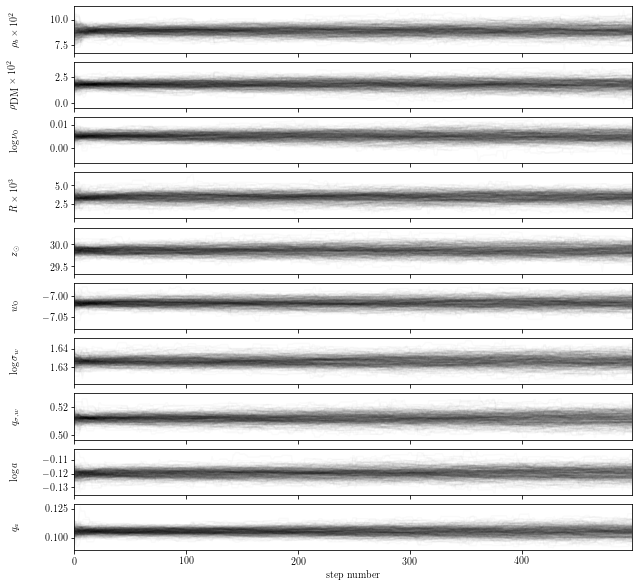

In [15]:
labels = [r'$\rho_b\times 10^2$', r'$\rho_{\textup{DM}}\times 10^2$', r'$\log \nu_0$', 
          r'$R\times 10^3$', r'$z_{\odot}$', r'$w_0$', 
          r'$\log \sigma_{w}$', r'$q_{\sigma,w}$', r'$\log a$', r'$q_a$']
labs = ['rhob', 'rhoDM', 'log_nu0', 'R', 'zsun', 'w0', 'log_sigmaw', 'q_sigmaw', 'log_a', 'q_a']
indexes = [12, 24, 25, 26, 27, 28, 29, 30, 31, 32]

params = get_params(chain, indexes, labs)
plot_chain(params, labels, figsize=(10,10), alpha=0.02)

### long

In [16]:
p0_next = chain[-1]
t0 = time()
chain = dm.mcmc(2000, nwalkers, p0_next, zdata, wdata, locs, scales, dz=1, verbose=True, parallel=True)
print(time() - t0, "s")
chain.shape

64.03291344642639 s


(2000, 332, 33)

10it [00:01,  7.85it/s]


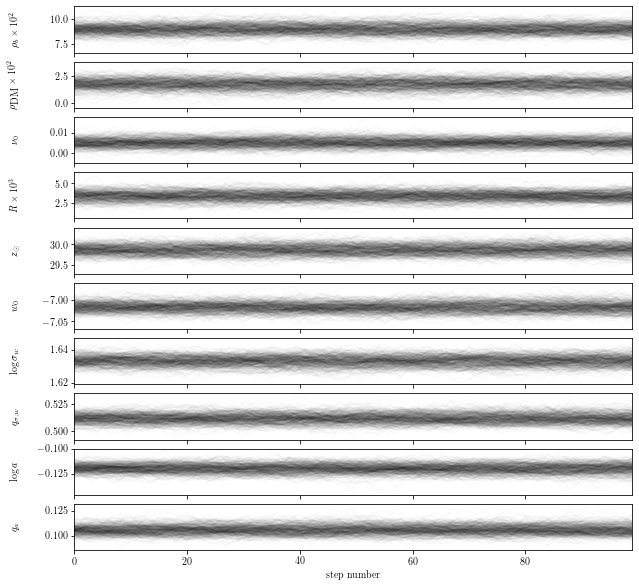

In [17]:
thin = 20
labels = [r'$\rho_b\times 10^2$', r'$\rho_{\textup{DM}}\times 10^2$', r'$\nu_0$', 
          r'$R\times 10^3$', r'$z_{\odot}$', r'$w_0$', 
          r'$\log \sigma_{w}$', r'$q_{\sigma,w}$', r'$\log a$', r'$q_a$']
labs = ['rhob', 'rhoDM', 'nu0', 'R', 'zsun', 'w0', 'log_sigmaw', 'q_sigmaw', 'log_a', 'q_a']
indexes = [12, 24, 25, 26, 27, 28, 29, 30, 31, 32]

params = get_params(chain[::thin], indexes, labs)
plot_chain(params, labels, figsize=(10,10), alpha=0.02)

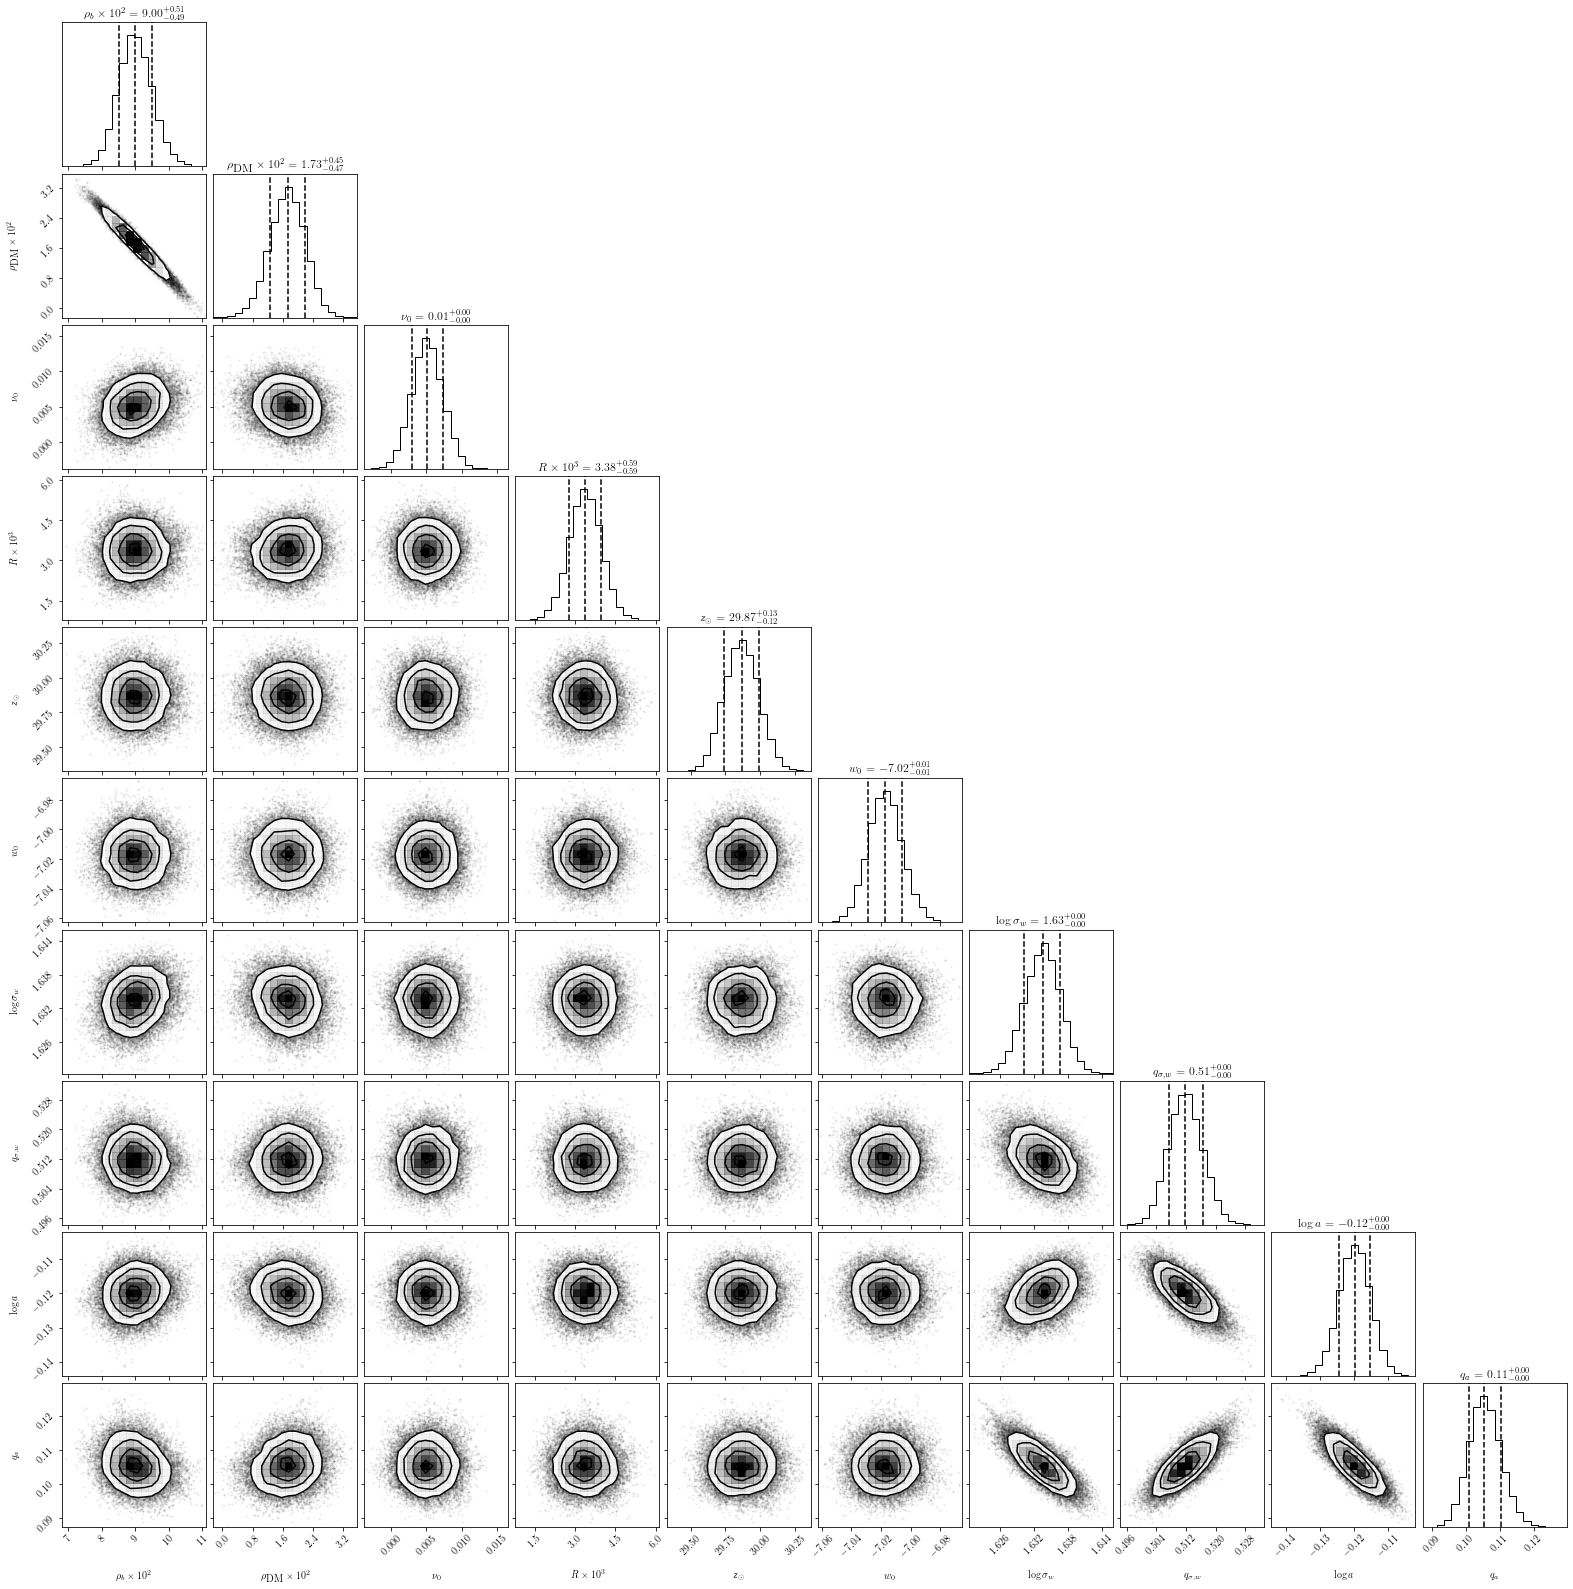

In [18]:
labels = [r'$\rho_b\times 10^2$', r'$\rho_{\textup{DM}}\times 10^2$', r'$\nu_0$', 
          r'$R\times 10^3$', r'$z_{\odot}$', r'$w_0$', 
          r'$\log \sigma_{w}$', r'$q_{\sigma,w}$', r'$\log a$', r'$q_a$']
labs = ['rhob', 'rhoDM', 'nu0', 'R', 'zsun', 'w0', 'log_sigmaw', 'q_sigmaw', 'log_a', 'q_a']
indexes = [12, 24, 25, 26, 27, 28, 29, 30, 31, 32]
chain_thin = chain[::thin]

params = get_params(chain_thin, indexes, labs)
plot_corner(params, labels)

(33200, 33)


100%|██████████| 5000/5000 [00:04<00:00, 1225.29it/s]


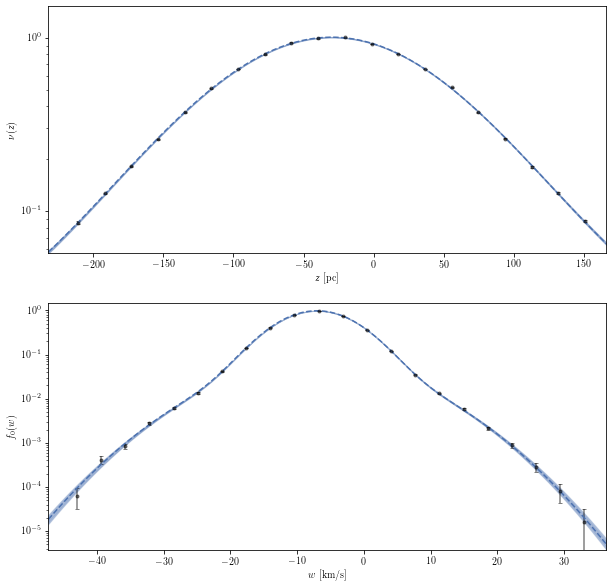

In [19]:
plot_fit(dm, zdata, wdata, chain_thin, ndim, n=5_000)

In [39]:
probs = calculate_probs(dm, chain_thin, ndim, zdata, wdata, locs, scales)

In [ ]:
prior = probs[:, 0]
likelihood = probs[:, 2]
posterior = probs[:, 1]
# plot histogram of probabilities
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].hist(prior, bins=100)
axes[0].set_xlabel('prior')
axes[1].hist(likelihood, bins=100)
axes[1].set_xlabel('likelihood')
axes[2].hist(posterior, bins=100)
axes[2].set_xlabel('posterior')
plt.show()
likelihood.max()

The script for comparing also implemented in `script` folder.